In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

from emoclass import *

In [2]:
NUM_CLASSES = len(emocat)
IMG_SIZE = 128
BATCH_SIZE = 8

folder_path = '/home/studenti/ballerini/datasets/RAVDESS_frames'

face_dataset = FaceEmotionDataset(root_dir=folder_path,
                                    transform=transforms.Compose([
                                        Rescale(IMG_SIZE), 
                                        CenterCrop(IMG_SIZE), 
                                        ToTensor()
                                    ]))        

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len

print('training set size: ', trainingset_len)
print('test set size: ', testset_len)

train_set, test_set = torch.utils.data.random_split(face_dataset, [trainingset_len,testset_len])

trainset_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=20)

testset_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=20)


dataset_loader = (trainset_loader, testset_loader)

training set size:  6480
test set size:  720


fearful


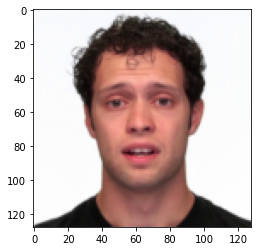

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(sample):
    plt.imshow(sample['image'].permute(1, 2, 0))
    print(emocat[sample['cat'].item()])
    
imageshow(train_set[0])

In [4]:
loss_fn = nn.CrossEntropyLoss()
model = EmoClassCNN(IMG_SIZE, NUM_CLASSES).double()

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

The model will be running on cuda:0 device


  0%|                                                                                                         | 0/15 [00:00<?, ?it/s]

For epoch 1 the test accuracy over the whole test set is 13 %


  7%|██████▍                                                                                          | 1/15 [00:44<10:28, 44.89s/it]

For epoch 2 the test accuracy over the whole test set is 28 %


 13%|████████████▉                                                                                    | 2/15 [01:29<09:39, 44.55s/it]

For epoch 3 the test accuracy over the whole test set is 54 %


 20%|███████████████████▍                                                                             | 3/15 [02:13<08:53, 44.47s/it]

For epoch 4 the test accuracy over the whole test set is 68 %


 27%|█████████████████████████▊                                                                       | 4/15 [02:58<08:11, 44.67s/it]

For epoch 5 the test accuracy over the whole test set is 74 %


 33%|████████████████████████████████▎                                                                | 5/15 [03:43<07:27, 44.70s/it]

For epoch 6 the test accuracy over the whole test set is 78 %


 40%|██████████████████████████████████████▊                                                          | 6/15 [04:28<06:43, 44.82s/it]

For epoch 7 the test accuracy over the whole test set is 80 %


 53%|███████████████████████████████████████████████████▋                                             | 8/15 [05:56<05:10, 44.38s/it]

For epoch 8 the test accuracy over the whole test set is 77 %


 60%|██████████████████████████████████████████████████████████▏                                      | 9/15 [06:40<04:25, 44.33s/it]

For epoch 9 the test accuracy over the whole test set is 79 %
For epoch 10 the test accuracy over the whole test set is 82 %


 73%|██████████████████████████████████████████████████████████████████████▍                         | 11/15 [08:09<02:57, 44.32s/it]

For epoch 11 the test accuracy over the whole test set is 81 %


 80%|████████████████████████████████████████████████████████████████████████████▊                   | 12/15 [08:52<02:11, 43.80s/it]

For epoch 12 the test accuracy over the whole test set is 80 %


 87%|███████████████████████████████████████████████████████████████████████████████████▏            | 13/15 [09:36<01:27, 43.85s/it]

For epoch 13 the test accuracy over the whole test set is 82 %
For epoch 14 the test accuracy over the whole test set is 83 %


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:04<00:00, 44.33s/it]

For epoch 15 the test accuracy over the whole test set is 81 %
Finished Training


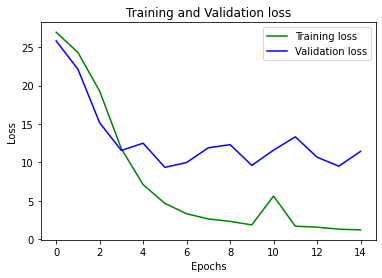

In [5]:
training = True

if training:
    NUM_EPOCHS = 15 
    training_loss, test_loss = train(model, dataset_loader, loss_fn, optimizer, NUM_EPOCHS)
    print('Finished Training')
    epochs = range(0, NUM_EPOCHS)
    plt.plot(epochs, training_loss, 'g', label='Training loss')
    plt.plot(epochs, test_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    path = "emoClassModel.pth"
    model.load_state_dict(torch.load(path))

Accuracy:  81.11111111111111


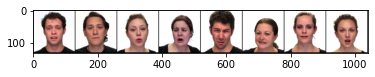

Real labels:  fearful happy neutral disgust disgust angry  calm surprised
Predicted:  fearful happy neutral disgust disgust angry  calm surprised


In [6]:
# Test which classes performed well
accuracy, _ = testAccuracy(model, testset_loader, loss_fn)
print('Accuracy: ', accuracy)

# Test with batch of images
testBatch(model, trainset_loader)

In [ ]:
testClassess(model, testset_loader, 8)

 23%|██████████████████████▍                                                                         | 21/90 [01:01<03:15,  2.83s/it]